In [160]:
!pip install talib-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [161]:
#przetwarzanie  
import pandas as pd
import numpy as np
#współczynniki analizy technicznej 
import talib as tb
from talib import abstract
#model
from sklearn.preprocessing import PolynomialFeatures
import joblib
# współczynnik oceny 
from sklearn.metrics import mean_absolute_error
# wizualizacja   
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
from pandas.plotting import scatter_matrix

In [162]:
gold = pd.read_csv('/content/gold.csv', sep=',', decimal='.')
gold 

,Date,Open,High,Low,Close,Volume,Currency
0,2000-01-04,281.0,281.0,281.00,282.7,4,USD
1,2000-01-05,283.2,283.2,283.20,281.1,16,USD
2,2000-01-06,281.4,281.4,281.40,281.4,0,USD
3,2000-01-07,281.9,281.9,281.90,281.9,0,USD
4,2000-01-10,281.7,281.7,281.70,281.7,0,USD
...,...,...,...,...,...,...,...
5757,2022-06-29,1821.4,1834.9,1810.70,1817.5,155542,USD
5758,2022-06-30,1819.2,1826.8,1802.50,1807.3,208898,USD
5759,2022-07-01,1808.1,1813.6,1783.40,1801.5,249489,USD
5760,2022-07-03,1812.5,1814.2,1809.05,1809.1,0,USD


In [163]:
gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5762 entries, 0 to 5761
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      5762 non-null   object 
 1   Open      5762 non-null   float64
 2   High      5762 non-null   float64
 3   Low       5762 non-null   float64
 4   Close     5762 non-null   float64
 5   Volume    5762 non-null   int64  
 6   Currency  5762 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 315.2+ KB


In [164]:
gold['Date']= pd.to_datetime(gold['Date'])
gold.set_index(['Date'],inplace= True)

In [165]:
gold = gold.loc[gold.index>='2022-04-10',:]
gold = gold.loc[:,:'Volume']
gold.head()

,Open,High,Low,Close,Volume
Date,,,,,
2022-04-11,1957.1,1981.2,1949.9,1955.0,5741
2022-04-12,1965.0,1989.1,1960.4,1983.0,9081
2022-04-13,1976.6,1992.2,1974.0,1991.5,9405
2022-04-14,1988.7,1990.6,1969.6,1981.6,3131
2022-04-18,1983.1,2009.5,1981.8,1993.3,1597


In [166]:
gold['tick']=((gold['Close'].shift(-1)- gold["Close"])/gold['Close'])*100
gold

,Open,High,Low,Close,Volume,tick
Date,,,,,,
2022-04-11,1957.1,1981.2,1949.90,1955.0,5741,1.432225
2022-04-12,1965.0,1989.1,1960.40,1983.0,9081,0.428643
2022-04-13,1976.6,1992.2,1974.00,1991.5,9405,-0.497113
2022-04-14,1988.7,1990.6,1969.60,1981.6,3131,0.590432
2022-04-18,1983.1,2009.5,1981.80,1993.3,1597,-1.379622
...,...,...,...,...,...,...
2022-06-29,1821.4,1834.9,1810.70,1817.5,155542,-0.561210
2022-06-30,1819.2,1826.8,1802.50,1807.3,208898,-0.320921
2022-07-01,1808.1,1813.6,1783.40,1801.5,249489,0.421871


In [167]:
def indicators(High, Low, Close, Volume):

  RSI_14day= tb.RSI(Close, timeperiod=14)

  MA_14day = tb.MA(Close, timeperiod=14, matype=0)

  MACD, MACDsignal, MACDhist = tb.MACD(Close, fastperiod=12, slowperiod=26, signalperiod=9)

  ROC = tb.ROC(Close, timeperiod=14)

  ADX_14day = tb.ADX(High, Low, Close, timeperiod=14) 

  BBANDS_U_14day = tb.BBANDS(Close, timeperiod=14, nbdevup=2, nbdevdn=2, matype=0)[0] 

  BBANDS_M_14day = tb.BBANDS(Close, timeperiod=14, nbdevup=2, nbdevdn=2, matype=0)[1] 
                     
  BBANDS_L_14day = tb.BBANDS(Close, timeperiod=14, nbdevup=2, nbdevdn=2, matype=0)[2] 

  ATR_14day = tb.ATR(High, Low, Close, timeperiod=14)  
  

  return pd.DataFrame({'RSI_14day':RSI_14day ,'MA_14day': MA_14day, 'MACD':MACD,'MACDsignal':MACDsignal,'ROC':ROC, 'ADX_14day':ADX_14day, 'BBANDS_U_14day': BBANDS_U_14day, 
                      'BBANDS_M_14day': BBANDS_M_14day,'BBANDS_L_14day':BBANDS_L_14day, 'ATR_14day':ATR_14day})

In [168]:
gold_indicators = indicators(gold['High'], gold['Low'], gold['Close'],gold['Volume'])
gold_price= pd.merge(gold,gold_indicators,on=gold.index)
gold_price.dropna(inplace=True)
gold_price =gold_price.drop('key_0', axis=1)
gold_price

,Open,High,Low,Close,Volume,tick,RSI_14day,MA_14day,MACD,MACDsignal,ROC,ADX_14day,BBANDS_U_14day,BBANDS_M_14day,BBANDS_L_14day,ATR_14day
33,1855.10,1866.90,1851.90,1857.30,123764,-0.519571,44.491787,1843.514286,-26.496484,-38.058465,-0.460904,33.087569,1876.940781,1843.514286,1810.087790,26.623424
34,1850.55,1851.76,1845.90,1847.65,0,0.419452,41.941946,1843.460714,-25.047400,-35.456252,-0.040576,31.946986,1876.858109,1843.460714,1810.063320,25.536037
35,1847.79,1862.10,1846.54,1855.40,0,-0.377277,44.683802,1843.060714,-23.008403,-32.966682,-0.300913,30.306247,1875.734561,1843.060714,1810.386868,24.823463
36,1856.50,1867.90,1837.60,1848.40,201803,0.016230,42.721311,1844.260714,-21.707099,-30.714766,0.917231,29.178004,1876.392278,1844.260714,1812.129150,25.214644
37,1840.00,1853.00,1830.20,1848.70,158036,1.227890,42.837183,1846.682143,-20.416254,-28.655063,1.867974,28.444288,1874.370294,1846.682143,1818.993992,25.042169
38,1849.90,1874.40,1846.50,1871.40,127471,-1.132842,50.926669,1850.325000,-17.361417,-26.396334,2.801582,26.590779,1876.607279,1850.325000,1824.042721,25.246300
39,1872.60,1878.60,1849.70,1850.20,115343,-0.351313,44.581327,1852.096429,-16.461344,-24.409336,1.358606,24.720719,1874.472962,1852.096429,1829.719895,25.507279
40,1853.70,1861.20,1843.00,1843.70,103179,0.455606,42.819694,1853.617857,-16.087083,-22.744885,1.168788,23.258691,1869.730834,1853.617857,1837.504881,24.985330
41,1843.50,1858.20,1838.50,1852.10,119211,0.237568,45.800335,1853.925000,-14.940444,-21.183997,0.232709,22.123321,1869.743920,1853.925000,1838.106080,24.607807
42,1855.00,1862.40,1846.60,1856.50,114141,-0.199300,47.348552,1854.503571,-13.520822,-19.651362,0.438217,20.826505,1870.062238,1854.503571,1838.944905,23.978678


In [169]:
gold_price_final = gold_price.loc[:,['RSI_14day',	'MA_14day',	'MACD','MACDsignal','ROC','ADX_14day','BBANDS_U_14day','BBANDS_M_14day','BBANDS_L_14day',	'ATR_14day']]
gold_price_final

,RSI_14day,MA_14day,MACD,MACDsignal,ROC,ADX_14day,BBANDS_U_14day,BBANDS_M_14day,BBANDS_L_14day,ATR_14day
33,44.491787,1843.514286,-26.496484,-38.058465,-0.460904,33.087569,1876.940781,1843.514286,1810.087790,26.623424
34,41.941946,1843.460714,-25.047400,-35.456252,-0.040576,31.946986,1876.858109,1843.460714,1810.063320,25.536037
35,44.683802,1843.060714,-23.008403,-32.966682,-0.300913,30.306247,1875.734561,1843.060714,1810.386868,24.823463
36,42.721311,1844.260714,-21.707099,-30.714766,0.917231,29.178004,1876.392278,1844.260714,1812.129150,25.214644
37,42.837183,1846.682143,-20.416254,-28.655063,1.867974,28.444288,1874.370294,1846.682143,1818.993992,25.042169
38,50.926669,1850.325000,-17.361417,-26.396334,2.801582,26.590779,1876.607279,1850.325000,1824.042721,25.246300
39,44.581327,1852.096429,-16.461344,-24.409336,1.358606,24.720719,1874.472962,1852.096429,1829.719895,25.507279
40,42.819694,1853.617857,-16.087083,-22.744885,1.168788,23.258691,1869.730834,1853.617857,1837.504881,24.985330
41,45.800335,1853.925000,-14.940444,-21.183997,0.232709,22.123321,1869.743920,1853.925000,1838.106080,24.607807
42,47.348552,1854.503571,-13.520822,-19.651362,0.438217,20.826505,1870.062238,1854.503571,1838.944905,23.978678


In [170]:
model_opened = joblib.load('model_polynomial_degrre_1.pkl')
model_opened

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('log_transformer',
                                                                   PowerTransformer()),
                                                                  ('scalar',
                                                                   StandardScaler()),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures(degree=1))]),
                                                  Index(['RSI_14day', 'MA_14day', 'MACD', 'MACDsignal', 'ROC', 'ADX_14day',
       'BBANDS_U_14day', 'BBANDS_M_14day', 'BBANDS_L_14day', 'ATR_14day'],
      dtype='object'))])),
                ('regressor', LinearRegression())])

In [171]:
gold_tick_predict = model_opened.predict(gold_price_final)

In [172]:
gold_real_tick= gold_price['tick']

In [173]:
print(f'MAE: {round(mean_absolute_error(gold_real_tick, gold_tick_predict),2)}')

MAE: 1.06


In [174]:
def visualization_of_the_results(predict):

  
  plt.scatter(x = predict, y = gold_real_tick, alpha=0.25)

  xmin, xmax = gold_real_tick.min(), gold_real_tick.max()
  x_line = np.linspace(xmin, xmax, 10)
  y_line = x_line
  # Oczekiwana linia trendu
  plt.plot(x_line, y_line, 'r--')

  plt.xlabel('Prediction')
  plt.ylabel('True value')
  plt.title('Plot of predicted values versus true values')
  plt.show()

  
  errors = predict - gold_real_tick
  plt.scatter(x = gold_real_tick, y= errors, alpha=0.25)
  plt.axhline(0, color='r', linestyle='--')
  plt.xlabel('True values')
  plt.ylabel('Residuals')
  plt.title('Plot of residuals')
  plt.show()

  
  print(f'Error mean: {errors.mean()}')

  plt.hist(errors, bins=20)
  plt.axvline(errors.mean(), color='k', linestyle='dashed', linewidth=1)
  plt.title('Histogram of residuals')
  plt.show()

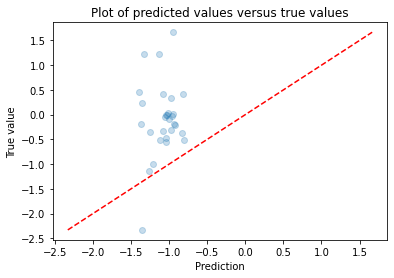

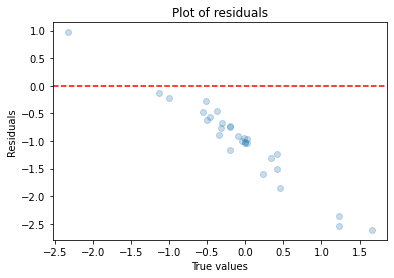

Error mean: -0.9886495113564719


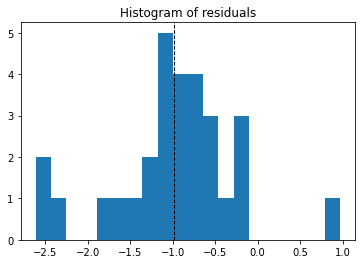

In [175]:
visualization_of_the_results(gold_tick_predict)